## Backward particle tracking through a steady-state flow field on an unstructured (DISV quadtree) grid

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 2 from the MODPATH 7 documentation. This example problem demonstrates a steady-state MODFLOW 6 simulation using a quadpatch DISV grid.

In part A, 16 particles are evenly distributed around the 4 side faces of a cell containing a well in a locally-refined region in the center of the grid, then tracked backwards to recharge locations at the water table.

In part B, 100 particles are evenly distributed around the 4 side faces of the well's cell, with 16 additional particles distributed over the cell's top face, then particles are again tracked backwards to recharge locations at the water table.

### Problem setup

First import dependencies.

In [1]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import MultiPoint, LineString
import flopy
from flopy.utils.gridintersect import GridIntersect
import numpy as np

# append the common/ subdirectory to the system path
sys.path.append(os.path.join("..", "common"))
import config
from figspecs import USGSFigure

Define simulation and model name and workspace.

In [2]:
sim_name = "mp7-p02"
gwf_name = sim_name
prt_name = sim_name + "_prt"
mp7_name = sim_name + "_mp7"
example_name = "ex-prt-" + sim_name

ws = config.base_ws
sim_ws = Path(ws) / example_name

gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"

# We only need 1 working directory for the GWF model
# since it can be reused for both subproblems A & B.
# The PRT and MP7 models each need separate working
# directories for each subproblem.
gwf_ws.mkdir(exist_ok=True, parents=True)

headfile = "{}.hds".format(gwf_name)
headfile_bkwd = "{}.hds".format(gwf_name + "_bkwd")
budgetfile = "{}.cbb".format(gwf_name)
budgetfile_bkwd = "{}.cbb".format(gwf_name + "_bkwd")
budgetfile_prt = "{}.cbb".format(prt_name)

Define model units.

In [3]:
length_units = "feet"
time_units = "days"

Define time discretization parameters.

In [4]:
tdis_rc = [(1000.0, 1, 1.0)]
nper = len(tdis_rc)

Define MODFLOW 6 flow model parameters.

In [5]:
# Cell types by layer
icelltype = [1, 0, 0]

# Conductivities
k = [50.0, 0.01, 200.0]
k33 = [10.0, 0.01, 20.0]

# Well
# issue(flopyex): in the original flopy example, the well
#   coordinates were at the edge (not the center) of the cell,
#   but it apparently worked out anyway
wel_coords = [(4718.45, 5281.25)]
wel_q = [-150000.0]

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 318.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1

Initialize globally available lists of well and river cells, which will be filled when the MODFLOW 6 flow model is built.

In [6]:
welcells = []
rivcells = []

### Grid refinement

[GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) can be used to create a quadpatch grid with a central refined region.

The grid will have 3 refinement levels. First, create the top-level (base) grid discretization.

In [7]:
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Refine the grid.

In [8]:
from flopy.utils.gridgen import Gridgen

# create Gridgen workspace
gridgen_ws = sim_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws)

# add polygon for each refinement level
outer_polygon = [
    [
        (3500, 4000),
        (6000, 4000),
        (6000, 6500),
        (3500, 6500),
        (3500, 4000),
    ]
]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [
        (4000, 4500),
        (5500, 4500),
        (5500, 6000),
        (4000, 6000),
        (4000, 4500),
    ]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [
    [
        (4500, 5000),
        (5000, 5000),
        (5000, 5500),
        (4500, 5500),
        (4500, 5000),
    ]
]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Build the grid and plot it with refinement levels superimposed.

Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but w

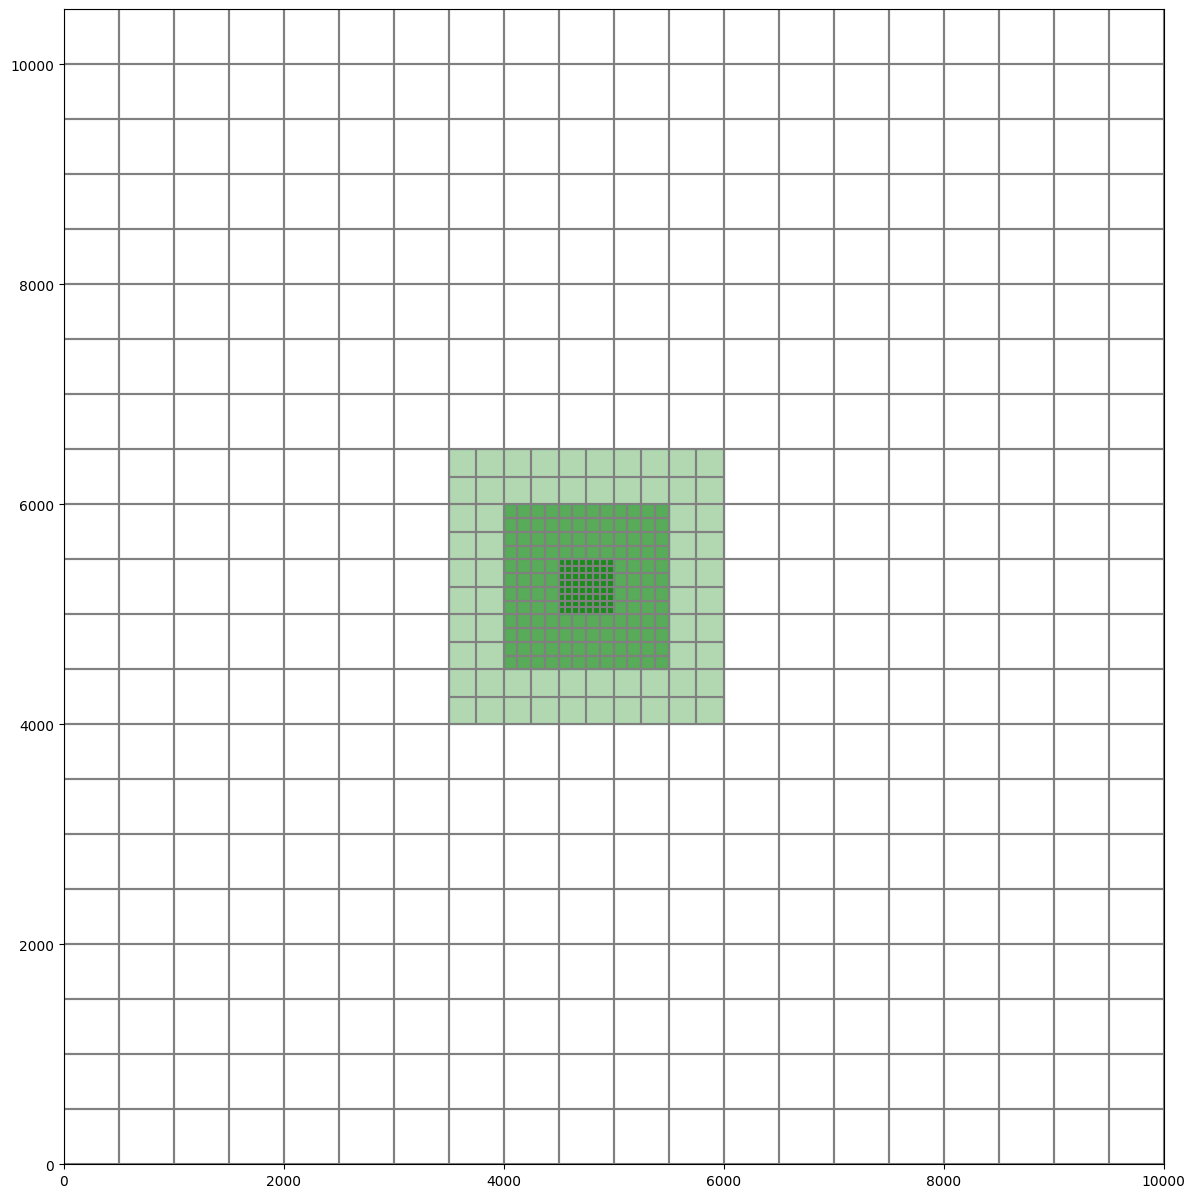

In [9]:
g.build(verbose=False)
grid_props = g.get_gridprops_vertexgrid()
disv_props = g.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)

flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.3)
flopy.plot.plot_shapefile(refshp1, ax=ax, facecolor="green", alpha=0.5)
flopy.plot.plot_shapefile(str(refshp2), ax=ax, facecolor="green", alpha=0.7)

In [10]:
import pickle

gpfname = os.path.join(config.data_ws, example_name, 'gridprops.pickle')
with open(gpfname, 'rb') as gpf:
    gridprops = pickle.load(gpf)

ncpl = gridprops["ncpl"]
top = gridprops["top"]
botm = gridprops["botm"]
nvert = gridprops["nvert"]
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]

assert np.array_equal(disv_props["ncpl"], ncpl)
assert np.array_equal(disv_props["top"], top)
assert np.array_equal(disv_props["botm"], botm)
assert np.array_equal(disv_props["nvert"], nvert)
assert np.array_equal(disv_props["vertices"], vertices)
# assert np.array_equal(disv_props["cell2d"], cell2d)

### Model creation

We are now ready to setup groundwater flow and particle tracking models.

Define shared MODFLOW 6 PRT and MODPATH 7 particle-tracking model parameters.

In [11]:
# Porosity
porosity = 0.1

Define particle release points for the PRT model. Note that release points for part A and B are not identical, with more particles released in part B.

In [12]:
releasepts = []

def set_releasepts(part):

    from math import sqrt
    global releasepts

    welcellnode = welcells[0]
    xctr = cell2d[welcellnode][1]
    yctr = cell2d[welcellnode][2]
    vert0 = cell2d[welcellnode][4]
    vert1 = cell2d[welcellnode][5]
    x0 = vertices[vert0][1]
    y0 = vertices[vert0][2]
    x1 = vertices[vert1][1]
    y1 = vertices[vert1][2]
    dx = x1 - x0
    dy = y1 - y0
    delcell = sqrt(dx * dx + dy * dy)
    delcellhalf = 0.5 * delcell

    # Reinitialize for the current scenario
    releasepts = []

    if part == "a":

        # Example 2A

        zrpt = 0.5 * (botm[1][welcellnode] + botm[2][welcellnode])
        npart_on_side = 4
        delta = delcell / npart_on_side
        baseoffset = 0.5 * (npart_on_side + 1) * delta
        xbase = xctr - baseoffset
        ybase = yctr - baseoffset
        nrpt = -1
        for idiv in range(npart_on_side):
            i = idiv + 1
            xrpt = xbase + i * delta
            yrpt = yctr + delcellhalf
            nrpt += 1
            rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
            releasepts.append(rpt)
            yrpt = yctr - delcellhalf
            nrpt += 1
            rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
            releasepts.append(rpt)
            yrpt = ybase + i * delta
            xrpt = xctr + delcellhalf
            nrpt += 1
            rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
            releasepts.append(rpt)
            xrpt = xctr - delcellhalf
            nrpt += 1
            rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
            releasepts.append(rpt)

    else:

        # Example 2B

        # 4x4 array of particles on top of well cell
        zrpt = botm[1][welcellnode]
        npart_on_side = 4
        delta = delcell / npart_on_side
        baseoffset = 0.5 * (npart_on_side + 1) * delta
        xbase = xctr - baseoffset
        ybase = yctr - baseoffset
        nrpt = -1
        for idivx in range(npart_on_side):
            ix = idivx + 1
            xrpt = xbase + ix * delta
            for idivy in range(npart_on_side):
                iy = idivy + 1
                yrpt = ybase + iy * delta
                nrpt += 1
                rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
                releasepts.append(rpt)
        # 10x10 arrays of particles on the four sides of well cell
        zwel = 0.5 * (botm[1][welcellnode] + botm[2][welcellnode])
        npart_on_side = 10
        delcellz = botm[1][welcellnode] - botm[2][welcellnode]
        delta = delcell / npart_on_side
        deltaz = delcellz / npart_on_side
        baseoffset = 0.5 * (npart_on_side + 1) * delta
        baseoffsetz = 0.5 * (npart_on_side + 1) * deltaz
        xbase = xctr - baseoffset
        ybase = yctr - baseoffset
        zbase = zwel - baseoffsetz
        for idivz in range(npart_on_side):
            iz = idivz + 1
            zrpt = zbase + iz * deltaz
            for idiv in range(npart_on_side):
                i = idiv + 1
                xrpt = xbase + i * delta
                yrpt = yctr + delcellhalf
                nrpt += 1
                rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
                releasepts.append(rpt)
                yrpt = yctr - delcellhalf
                nrpt += 1
                rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
                releasepts.append(rpt)
                yrpt = ybase + i * delta
                xrpt = xctr + delcellhalf
                nrpt += 1
                rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
                releasepts.append(rpt)
                xrpt = xctr - delcellhalf
                nrpt += 1
                rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
                releasepts.append(rpt)

Define particle release points for the MODPATH 7 model.

In [13]:
def particle_data(part):
    nodew = ncpl * 2 + welcells[0]

    if part == "a":

        # Example 2A
        pcoord = np.array(
            [
                [0.000, 0.125, 0.500],
                [0.000, 0.375, 0.500],
                [0.000, 0.625, 0.500],
                [0.000, 0.875, 0.500],
                [1.000, 0.125, 0.500],
                [1.000, 0.375, 0.500],
                [1.000, 0.625, 0.500],
                [1.000, 0.875, 0.500],
                [0.125, 0.000, 0.500],
                [0.375, 0.000, 0.500],
                [0.625, 0.000, 0.500],
                [0.875, 0.000, 0.500],
                [0.125, 1.000, 0.500],
                [0.375, 1.000, 0.500],
                [0.625, 1.000, 0.500],
                [0.875, 1.000, 0.500],
            ]
        )
        plocs = [nodew for i in range(pcoord.shape[0])]
        pgdata = flopy.modpath.ParticleData(
            plocs,
            structured=False,
            localx=pcoord[:, 0],
            localy=pcoord[:, 1],
            localz=pcoord[:, 2],
            drape=0,
        )

    else:

        # Example 2B
        facedata = flopy.modpath.FaceDataType(
            drape=0,
            verticaldivisions1=10,
            horizontaldivisions1=10,
            verticaldivisions2=10,
            horizontaldivisions2=10,
            verticaldivisions3=10,
            horizontaldivisions3=10,
            verticaldivisions4=10,
            horizontaldivisions4=10,
            rowdivisions5=0,
            columndivisions5=0,
            rowdivisions6=4,
            columndivisions6=4,
        )
        pgdata = flopy.modpath.NodeParticleData(subdivisiondata=facedata, nodes=nodew)

    return pgdata

Define some variables used to plot model results.

In [14]:
# colormap for boundary locations
cmapbd = mpl.colors.ListedColormap(["r", "g",])

# time series point colors by layer
colors = ["green", "orange", "red"]

# figure sizes
figure_size_solo = (8.0, 8.0)
figure_size_compare = (15, 6)

Define functions to build, write, run, and plot models.

Below we use three distinct simulations:

  1. MODFLOW 6 GWF (groundwater flow)
  2. MODFLOW 6 PRT (particle-tracking)
  3. MODPATH 7 particle-tracking

In [15]:
def build_mf6gwf():

    global welcells, rivcells

    print("Building GWF model")

    # ====================================
    # Create the MODFLOW 6 flow simulation
    # ====================================
    
    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name=config.mf6_exe, version="mf6", sim_ws=gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
    )

    # -------------------
    # Build the GWF model
    # -------------------

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file="{}.nam".format(gwf_name)
    )
    gwf.name_file.save_flows = True

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        **disv_props,
    )

    # GridIntersect object for setting up boundary conditions
    ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=riv_h)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=[("xt3d")],
        icelltype=icelltype,
        k=k, k33=k33,
        save_saturation=True, save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf, recharge=rch,
        auxiliary=["iface", "iflowface"], aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    welcells = ix.intersects(MultiPoint(wel_coords))
    welcells = [icpl for (icpl,) in welcells]
    welspd = [[(2, icpl), wel_q[idx]] for idx, icpl in enumerate(welcells)]
    flopy.mf6.ModflowGwfwel(
        gwf, print_input=True, stress_period_data=welspd
    )

    # Instantiate the MODFLOW 6 gwf river package
    riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
    rivcells = ix.intersects(LineString(riverline))
    rivcells = [icpl for (icpl,) in rivcells]
    rivspd = [[(0, icpl), riv_h, riv_c, riv_z, riv_iface, riv_iflowface]
              for icpl in rivcells]
    flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd,
        auxiliary=[("iface", "iflowface")])

    # Instantiate the MODFLOW 6 gwf output control package
    headfile = "{}.hds".format(gwf_name)
    head_record = [headfile]
    budgetfile = "{}.cbb".format(gwf_name)
    budget_record = [budgetfile]
    flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=budget_record,
        head_filerecord=head_record,
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    #---------------------------------------------------------------------
    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    #---------------------------------------------------------------------

    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        print_option="SUMMARY",
        complexity="SIMPLE",
        outer_dvclose=1.0e-5,
        outer_maximum=100,
        under_relaxation="NONE",
        inner_maximum=100,
        inner_dvclose=1.0e-6,
        rcloserecord=0.1,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=0.99,
    )
    sim.register_ims_package(ims, [gwf.name])

    #======================
    # Return the simulation
    #======================

    return sim

In [16]:
def build_mf6prt(part):
    print(f"Building PRT model for {example_name}{part}")

    # issue(mf6): plotting kluge requires file plot.in to be in
    #   the prt model workspace

    # Set particle release point data according to the scenario
    prpname = f"prp2{part}"
    prpfilename = f"{prt_name}_2{part}.prp"
    set_releasepts(part)
    nreleasepts = len(releasepts)

    prt_ws_scen = prt_ws.parent / (prt_ws.name + part)
    prt_ws_scen.mkdir(exist_ok=True)
    
    # Instantiate the MODFLOW 6 simulation object
    simprt = flopy.mf6.MFSimulation(
        sim_name=prt_name, version="mf6", exe_name=config.mf6_exe, sim_ws=prt_ws_scen
    )

    # Create a time discretization for backward tracking;
    # since there is only a single period with a single time step,
    # the time discretization is the same backward as forward
    tdis_bkwd = tdis_rc

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        simprt, pname="tdis", time_units="DAYS", perioddata=tdis_bkwd, nper=len(tdis_bkwd)
    )

    # -------------------
    # Build the PRT model
    # -------------------

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        simprt, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.ModflowGwfdisv(
        prt,
        length_units=length_units,
        **disv_props,
    )

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    pd = {0: ["FIRST"], 1: []}
    flopy.mf6.ModflowPrtprp(
        prt, pname=prpname, filename=prpfilename,
        nreleasepts=nreleasepts, packagedata=releasepts,
        perioddata=pd, 
    )

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile_prt = "{}.cbb".format(prt_name)
    budget_record = [budgetfile_prt]
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    # using "time-reversed" budget and head files
    pd = [
        ("GWFHEAD", headfile_bkwd),
        ("GWFBUDGET", budgetfile_bkwd),
    ]
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    #--------------------------------------------------------------------
    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    #--------------------------------------------------------------------

    # issue(flopy): using IMS until mfsimulation.py is updated for EMS by Scott
    # issue(mf6): code is kluged to create EMS if first model in IMS is a PRT
    ems = flopy.mf6.ModflowEms(
        simprt, pname="ems",
        filename="{}.ems".format(prt_name),
    )
    simprt.register_solution_package(ems, [prt.name])

    #======================
    # Return the simulation
    #======================

    return simprt

In [17]:
def build_mp7(part, gwf):
    print(f"Building mp7 model for {example_name}{part}")

    # Set parameters according to the scenario
    pgdata = particle_data(part)
    nm_mp7 = f"{mp7_name}{part}"
    pgname = f"BACKWARD2{part.upper()}"
    fpth = nm_mp7 + ".sloc"
    pg = flopy.modpath.ParticleGroupNodeTemplate(
        particlegroupname=pgname, particledata=pgdata, filename=fpth
    )
    if part == "a":
        simtype = "combined"
        timepointdata=[500, 1000.0]
    else:
        simtype = "endpoint"
        timepointdata=None

    # Instantiate the MODPATH 7 simulation object
    bfile = gwf_ws / budgetfile
    hfile = gwf_ws / headfile
    
    # create workspace for this scenario (part A or B)
    mp7_ws_scen = mp7_ws.parent / (mp7_ws.name + part)
    mp7_ws_scen.mkdir(exist_ok=True)

    mp7 = flopy.modpath.Modpath7(
        modelname=nm_mp7,
        flowmodel=gwf,
        exe_name=config.mp7_exe,
        model_ws=mp7_ws_scen,
        budgetfilename=budgetfile,
        headfilename=headfile
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity)

    # Instantiate the MODPATH 7 simulation data
    flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype=simtype,
        trackingdirection="backward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        referencetime=0.0,
        stoptimeoption="extend",
        timepointdata=timepointdata,
        particlegroups=pg,
    )

    # Return the simulation
    return mp7

In [18]:
def build_models(part):
    sim = build_mf6gwf()
    gwf = sim.get_model(gwf_name)
    simprt = build_mf6prt(part)
    mp7 = build_mp7(part, gwf)
    return sim, simprt, mp7

Function to write simulation/model input files.

In [19]:
def write_models(sim, simprt, mp7, silent=True):
    sim.write_simulation(silent=silent)
    simprt.write_simulation(silent=silent)
    mp7.write_input()

Because this problem tracks particles backwards, we need to reverse the head and budget files after running the groundwater flow model and before running the particle tracking model. Define functions to do this.

In [20]:
def reverse_budgetfile(part):

    import flopy.utils.binaryfile as bf

    # Create a reverse budget file for backward tracking;
    # since the flow budget file has only a single period
    # with a single time step, really only need to negate
    # the flows, but implementing the general procedure
    # anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load budget file and get number of records
    fpth = gwf_ws / budgetfile
    cbb = bf.CellBudgetFile(fpth)
    nrecords = cbb.get_nrecords()
    # Header array formats
    dt1 = np.dtype(
        [
            ("kstp", np.int32),
            ("kper", np.int32),
            ("text", "S16"),
            ("ndim1", np.int32),
            ("ndim2", np.int32),
            ("ndim3", np.int32),
            ("imeth", np.int32),
            ("delt", np.float64),
            ("pertim", np.float64),
            ("totim", np.float64),
        ]
    )
    dt2 = np.dtype(
        [
            ("text1id1", "S16"),
            ("text1id2", "S16"),
            ("text2id1", "S16"),
            ("text2id2", "S16"),
        ]
    )
    # Open backward budget file
    prt_ws_scen = prt_ws.parent / (prt_ws.name + part)
    fpth = prt_ws_scen / budgetfile_bkwd
    with open(fpth, "wb") as fbin:
        # Loop over budget file records in reverse order
        for idx in range(nrecords-1, -1 ,-1):
            # Load header array
            header = cbb.recordarray[idx]
            # Replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header['kstp'] - 1, header['kper'] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header['kstp'], header['kper']) = (kstpb + 1, kperb + 1)
            # Replace totim and pertim in the header array with their
            # backward counterparts
            header['totim'] = tsimtotal - header['totim']
            perlen = tdis_rc[kper][0]
            header['pertim'] = perlen - header['pertim']
            # Write main header information to backward budget file
            h = header[['kstp','kper','text',
                         'ncol','nrow','nlay',
                         'imeth','delt','pertim','totim',
                        ]]
            # Note: much of the code below is based on binary_file_writer.py
            h = np.array(h, dtype=dt1)
            h.tofile(fbin)
            if header['imeth'] == 6:
                # Write additional header information to the backward budget file
                h = header[['modelnam','paknam','modelnam2','paknam2',]]
                h = np.array(h, dtype=dt2)
                h.tofile(fbin)
                # Load data
                data = cbb.get_data(idx)[0]
                data = np.array(data)
                # Negate flows
                data['q'] = -data['q']
                # Write ndat (number of floating point columns)
                colnames = data.dtype.names
                ndat = len(colnames) - 2
                dt = np.dtype([("ndat", np.int32)])
                h = np.array([(ndat,)], dtype=dt)
                h.tofile(fbin)
                # Write auxiliary column names
                naux = ndat - 1
                if naux > 0:
                    auxtxt = ["{:16}".format(colname) for colname in colnames[3:]]
                    auxtxt = tuple(auxtxt)
                    dt = np.dtype([(colname, "S16") for colname in colnames[3:]])
                    h = np.array(auxtxt, dtype=dt)
                    h.tofile(fbin)
                # Write nlist
                nlist = data.shape[0]
                dt = np.dtype([("nlist", np.int32)])
                h = np.array([(nlist,)], dtype=dt)
                h.tofile(fbin)
            elif header['imeth'] == 1:
                # Load data
                data = cbb.get_data(idx)[0][0][0]
                data = np.array(data, dtype=np.float64)
                # Negate flows
                data = -data
            else:
                sys.exit("not expecting imeth " + header['imeth'])
            # Write data
            data.tofile(fbin)
    # Close backward budget file
    fbin.close()

def reverse_headfile(part):

    import flopy.utils.binaryfile as bf

    # Create a reverse head file for backward tracking;
    # since the head file has only a single period
    # with a single time step, not really necessary
    # to reverse it, but implementing the general
    # procedure anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load head file and get number of records
    fpth = gwf_ws / headfile
    hds = bf.HeadFile(fpth)
    # issue(flopy): HeadFile doesn't appear to have a get_records
    #   method like CellBudgetFile does
    #nrecords = hds.get_nrecords()
    nrecords = hds.recordarray.shape[0]
    # Header array formats
    dt = np.dtype(
        [
                ("kstp", np.int32),
                ("kper", np.int32),
                ("pertim", np.float64),
                ("totim", np.float64),
                ("text", "S16"),
                ("ncol", np.int32),
                ("nrow", np.int32),
                ("ilay", np.int32),
        ]
    )
    # Open backward head file
    prt_ws_scen = prt_ws.parent / (prt_ws.name + part)
    fpth = prt_ws_scen / headfile_bkwd
    with open(fpth, "wb") as fbin:
        # loop over head file records in reverse order
        for idx in range(nrecords-1, -1 ,-1):
            # load header array
            header = hds.recordarray[idx]
            # replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header['kstp'] - 1, header['kper'] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header['kstp'], header['kper']) = (kstpb + 1, kperb + 1)
            # replace totim and pertim in the header array with their
            # backward counterparts
            header['totim'] = tsimtotal - header['totim']
            perlen = tdis_rc[kper][0]
            header['pertim'] = perlen - header['pertim']
            # write header information to the backward head file
            h = np.array(header, dtype=dt)
            h.tofile(fbin)
            # load data
            data = hds.get_data(idx=idx)[0][0]
            data = np.array(data, dtype=np.float64)
            # write data
            data.tofile(fbin)
    # Close backward head file
    fbin.close()

In [21]:
# temporary utility function
def copy_grb_tdis(part):
    import shutil
    
    fname = gwf_name + ".disv.grb"
    filemf6 = gwf_ws / fname
    filemp7 = mp7_ws.parent / (mp7_ws.name + part) / fname
    cp = shutil.copyfile(filemf6, filemp7)

    fname = gwf_name + ".tdis"
    filemf6 = gwf_ws / fname
    filemp7 = mp7_ws.parent / (mp7_ws.name + part) / fname
    cp = shutil.copyfile(filemf6, filemp7)

Define a function to run all three simulations and their respective models.

In [21]:
@config.timeit
def run_models(part, sim, simprt, mp7, silent=True):
    success = True
    if config.runModel:
        # Run MODFLOW 6 flow simulation
        success, buff = sim.run_simulation(silent=silent, report=True)
        assert success
        for line in buff:
            print(line)

        # Process budget and head files for backward tracking
        reverse_budgetfile(part)
        reverse_headfile(part)

        # Run MODFLOW 6 PRT particle-tracking simulation
        success, buff = simprt.run_simulation(silent=silent, report=True)
        assert success
        for line in buff:
            print(line)

        # Run MODPATH 7 simulation
        success, buff = mp7.run_model(silent=silent, report=True)
        assert success
        for line in buff:
            print(line)
    return success

Define a function for reading and storing MODFLOW 6 PRT pathlines.

In [22]:
# issue(flopy): need general routine for loading prt pathline data
def load_mf6pathlines(cbb, prpnam=None):

    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    times = cbb.get_times()

    # Extract pathline data
    pdict = {}
    # For each time, read and parse particle data
    # and add it to a dictionary keyed on a particle identifier consisting
    # of release point number and release time
    for totim in times:
        data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
        for ploc in data[0]:
            # particle data read from the binary output file are in terms
            # of one-based indexing; will convert to zero-based indexing
            irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
            irpt -= 1
            node -= 1
            kp = node // ncpl
            # issue(mf6): particle ids not assigned yet in mf6
            pathpoint = (xp, yp, zp, ttrack, kp, 0)
            key = (irpt, trelease)
            # Note that repeat locations written for terminated particles
            # are not filtered out here, though they could be
            if key not in pdict:
                pdict[key] = [pathpoint]
            else:
                pdict[key].append(pathpoint)
    # Reformat into mf6pathlines array
    mf6pathlines = []
    for key in pdict:
        path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
        mf6pathlines.append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

Define a function for reading and storing MODFLOW 6 PRT endpoint data.

In [23]:
# issue(flopy): need general routine for loading prt endpoint data
def load_mf6endpointdata(cbb, prpnam=None):

    dtype={'names':['time0','time',
                    'node0','k0','x0','y0','z0',
                    'node','k','x','y','z',
                    'zone'],
           'formats':['<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4'],
          }
    times = cbb.get_times()

    # Extract endpoint data
    edict = {}
    # For each time, read and parse particle data
    # and store it in a dictionary keyed on a particle identifier consisting
    # of release point number and release time; later data overwrite earlier
    # data for the same key, ultimately resulting in the endpoint being stored;
    # alternatively, could read backwards in time, but would still need to
    # deal with repeat locations for terminated particles
    for totim in times:
        data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
        for ploc in data[0]:
            irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
            irpt -= 1
            node -= 1
            key = (irpt, trelease)
            # to facilitate meaningful travel times, do not include the repeat locations
            # that are written for a terminated particle
            if (key not in edict) or \
            node != edict[key][7] or xp != edict[key][9] or \
            yp != edict[key][10] or zp != edict[key][11]:
                rpt = releasepts[irpt]
                (krls, icpl) = rpt[1]
                noderls = krls * ncpl + icpl
                xrls = rpt[2]
                yrls = rpt[3]
                zrls = rpt[4]
                kp = (node - 1) // ncpl
                # issue(mf6): zone info not stored with particle locations,
                #   so hardwiring it to 0 in this problem
                zone = 0
                # issue(mf6): particle ids not assigned yet in mf6
                edict[key] = (trelease, ttrack,
                              noderls, krls, xrls, yrls, zrls,
                              node, kp, xp, yp, zp, zone)
        # Reformat into mf6endpointdata recarray
        mf6endpointdata = []
        for key in edict:
            mf6endpointdata.append(edict[key])
        mf6endpointdata = np.rec.array(mf6endpointdata, dtype=dtype)

    # Return mf6endpointdata
    return mf6endpointdata

Define a function for plotting flow model grid, boundary conditions, and head results.

In [24]:
def plot_gwf(sim, mg, ibd):
    
    # --------------------------------------
    # Subset of the model cells and vertices
    # --------------------------------------

    # Zoom area
    xmin, xmax = 2000, 4500
    ymin, ymax = 5400, 7500

    # Initialize plot
    fs = USGSFigure(figure_type="map", verbose=False)
    fig = plt.figure(figsize=figure_size_solo)
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
    v = mm.plot_grid(lw=0.5, edgecolor="black")
    t = ax.set_title("Model cells and vertices (one-based)\n", fontsize=14)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Vertices
    verts = mg.verts
    ax.plot(verts[:, 0], verts[:, 1], "bo")
    for i in range(ncpl):
        x, y = verts[i, 0], verts[i, 1]
        if xmin <= x <= xmax and ymin <= y <= ymax:
            ax.annotate(str(i + 1), verts[i, :], color="b")

    # Cell centers
    xc, yc = mg.get_xcellcenters_for_layer(0), mg.get_ycellcenters_for_layer(0)
    for i in range(ncpl):
        x, y = xc[i], yc[i]
        ax.plot(x, y, "ro")
        if xmin <= x <= xmax and ymin <= y <= ymax:
            ax.annotate(str(i + 1), (x, y), color="r")

    plt.show()

    # ------------------
    # Boundary locations
    # ------------------
        
    fs = USGSFigure(figure_type="map", verbose=False)
    fig = plt.figure(figsize=figure_size_solo)
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
    mm.plot_grid(lw=0.5)
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    pc = pmv.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
    t = ax.set_title("Boundary Conditions\n", fontsize=14)
        
    plt.show()

    # ------------
    # Head results
    # ------------

    # Import simulated head values from the binary head file
    fname = gwf_ws / (gwf_name + ".hds")
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()

    # Prepare a plot of heads in layer 3
    ilay = 2
    cint = 0.25
    fs = USGSFigure(figure_type="map", verbose=False)
    fig2 = plt.figure(figsize=figure_size_solo)
    fig2.tight_layout()
    ax = fig2.add_subplot(1, 1, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax, layer=ilay)
    mm.plot_grid(lw=0.5)
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    pc = mm.plot_array(head[:, 0, :], cmap="jet", edgecolor="black")
    hmin = head[ilay, 0, :].min()
    hmax = head[ilay, 0, :].max()
    levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
    cs = mm.contour_array(head[:, 0, :], colors="white", levels=levels)
    plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)
    cb = plt.colorbar(pc, shrink=0.5)
    t = ax.set_title(
        "Head in model Layer {}; hmin={:6.2f}, hmax={:6.2f}\n".format(ilay + 1, hmin, hmax),
        fontsize=14
    )
        
    plt.show()

Define a function for plotting pathlines and time series points colored by layer.

In [25]:
def plot_pathlines_and_timeseries(ax, mg, ibd, pathlines, timeseries, plottitle):

    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
    mm.plot_grid(lw=0.5)
    v = mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
    mm.plot_pathline(pathlines, layer="all", color="blue", lw=0.75)
    # issue(mf6): no way to output time series in prt
    if timeseries != None:
#        for k in range(nlay):
#            mm.plot_timeseries(timeseries, layer=k, marker="o", lw=0, color=colors[k]);
        for k in range(nlay-1, -1 ,-1):
            mm.plot_timeseries(timeseries, layer=k, marker="o", lw=0, color=colors[k]);
    ax.set_title(plottitle, fontsize=12)

    return

Define a utility function for plotting particle endpoints, colored by travel time to capture.

In [26]:
def plot_endpoints(ax, mg, ibd, endpointdata, plottitle):
    
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
    mm.plot_grid(lw=0.5)
    v = mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
    mm.plot_endpoint(endpointdata, direction="ending", colorbar=True, shrink=0.25)
    ax.set_title(plottitle, fontsize=12)

In [27]:
def plot_results(part, sim, simprt, mp7):
    
    import flopy.utils.binaryfile as bf

    # Get model grid
    fname = gwf_ws / (gwf_name + ".disv.grb")
    grd = flopy.mf6.utils.MfGrdFile(fname, verbose=False)
    mg = grd.modelgrid
    
    # Workspaces
    prt_ws_scen = prt_ws.parent / (prt_ws.name + part)
    mp7_ws_scen = mp7_ws.parent / (mp7_ws.name + part)

    # identify the boundary locations
    ibd = np.zeros((ncpl), dtype=int)
    ibd[np.array(welcells)] = 1
    ibd[np.array(rivcells)] = 2
    ibd = np.ma.masked_equal(ibd, 0)

    if part == "a":

        # =========================
        # MODFLOW 6 flow simulation
        # =========================

        plot_gwf(sim, mg, ibd)

        # ==========
        # Example 2A
        # ==========

        # MODFLOW 6 PRT budget file
        fpth = prt_ws_scen / budgetfile_prt
        cbb = bf.CellBudgetFile(fpth)

        # Load MODFLOW 6 PRT pathlines
        mf6pathlines = load_mf6pathlines(cbb)

        # Load MODPATH 7 pathlines
        fpth = mp7_ws_scen / (mp7_name + ".mppth")
        plf = flopy.utils.PathlineFile(fpth)
        mp7pathlines = plf.get_alldata()

        # Load MODPATH 7 timeseries
        fpth = mp7_ws_scen / (mp7_name + ".mppth")
        tsf = flopy.utils.PathlineFile(fpth)
        mp7timeseries = tsf.get_alldata()

        # ------------------------------------------------
        # Pathlines and time series point colored by layer
        # ------------------------------------------------

        # Initialize plot
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size_compare)
        plt.suptitle(t='Example 2A - Pathlines and time series points tracked backward from well',
                     fontsize=14)
        axes = axes.flatten()

        # MODFLOW 6 PRT
        ax = axes[0]
        # issue(mf6): no way to output time series
        plot_pathlines_and_timeseries(ax, mg, ibd, mf6pathlines, None, 'MODFLOW 6 PRT')

        # MODPATH 7
        ax = axes[1]
        plot_pathlines_and_timeseries(ax, mg, ibd, mp7pathlines, mp7timeseries, 'MODPATH 7')

        # Save figure
        if config.plotSave:
            fpth = os.path.join(
                "..", "figures", "{}-paths{}".format(sim_name, config.figure_ext)
            )
            fig.savefig(fpth)

    else:

        # ==========
        # Example 2B
        # ==========

        # MODFLOW 6 PRT budget file
        fpth = prt_ws_scen / budgetfile_prt
        cbb = bf.CellBudgetFile(fpth)

        # Load MODFLOW 6 PRT endpoint data
        mf6endpointdata = load_mf6endpointdata(cbb)

        # Load MODPATH 7 endpoint data
        fpth = mp7_ws / (mp7_name + ".mpend")
        epf = flopy.utils.EndpointFile(fpth)
        mp7endpointdata = epf.get_alldata()

        # -------------------------------------------
        # Endpoints colored by travel time to capture
        # -------------------------------------------

        # Initialize plot
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size_compare)
        plt.suptitle(t='Example 2B - Endpoints of particle paths tracked backward from well',
                     fontsize=14)
        axes = axes.flatten()

        # MODFLOW 6 PRT
        ax = axes[0]
        plot_endpoints(ax, mg, ibd, mf6endpointdata, 'MODFLOW 6 PRT')

        # MODPATH 7
        ax = axes[1]
        plot_endpoints(ax, mg, ibd, mp7endpointdata, 'MODPATH 7')
        
        # issue(flopy): the center "dot" looks to be in a slightly different location
        # in the two plots -- true even if you plot the very same endpoint array in both plots

        # Save figure
        if config.plotSave:
            fpth = os.path.join(
                "..", "figures", "{}-endpts{}".format(sim_name, config.figure_ext)
            )
            fig.savefig(fpth)

Define a function to wrap all of the steps for each scenario.

1. build model
2. write model
3. run model
4. plot results

In [28]:
def scenario(part, silent=True):
    sim, simprt, mp7 = build_models(part)
    write_models(sim, simprt, mp7, silent=silent)
    run_models(part, sim, simprt, mp7, silent=silent)
    plot_results(part, sim, simprt, mp7)

Run the scenario for problem 2A.

In [29]:
scenario("a")

Building GWF model
Building PRT model for ex-prt-mp7-p02a
Building mp7 model for ex-prt-mp7-p02a
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                               ***DEVELOP MODE***

        MODFLOW 6 compiled May 17 2023 10:23:42 with GCC version 13.1.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the 

In [ ]:
# Scenario for example 2B
scenario("b")

Building GWF model
Building PRT model for ex-prt-mp7-p02b
Building mp7 model for ex-prt-mp7-p02b
[]
run_models  424.79 ms
